# Detect Pneumonia Using X-Ray Images with CNNs

For this project, we assume the role of a Deep Learning Engineer at an R&D company and we are interested in using existing chest X-ray images to help identify patients with pneumonia. An accurate pneumonia classifier could help with detection automation and hopefully saving many more lives.

We have access to a dataset containing 5,856 chest X-ray images of patients with and without pneumonia. Some images are part of the training dataset and other images are part of the test set.

We will be using convolutional neural networks to help with the classification task. This network is going to be build using the tensorflow python package.

## Introduction

We are first going to upload our dataset in this google colab notebook (by running a shell command) and use a helper function to extract the data.

In [ ]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2025-11-11 10:06:26--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 54.231.200.17, 52.217.204.177, 52.217.231.201, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|54.231.200.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  58.0MB/s    in 20s     

2025-11-11 10:06:47 (57.3 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [ ]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=output_path)

In [ ]:
extract_tar_gz("xray_dataset.tar.gz", ".")

/tmp/ipython-input-2922500021.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_path)


Now that we have the datafile loaded in the notebook, we are going to import several libraries that we will need for this project. We are then going to use the images that we downloaded to train the model. For this, we need to create our dataloader objects. We will use a specific tensorflow method for this.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Key variables

img_size = 256
batch_size = 128
val_frac = 0.20
seed = 417
norm = 255

In [ ]:
train_set = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/train/",
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=val_frac,
    subset="training",
    seed=seed
)

val_set = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/train/",
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=val_frac,
    subset="validation",
    seed=seed
)

test_set = tf.keras.utils.image_dataset_from_directory(
    "chest_xray/test/",
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
norm_layer = layers.Rescaling(1/norm)

In [ ]:
train_set_norm = train_set.map(lambda x, y: (norm_layer(x), y))
val_set_norm = val_set.map(lambda x, y: (norm_layer(x), y))
test_set_norm = test_set.map(lambda x, y: (norm_layer(x), y))

We have successfully extracted all the datafiles and stored them in a training set, validation set and test set. All these data files have 2 classes (pneumonia or healthy).

The normalization layer is used to force all pixel color inputs to be in the 0 - 1 range (easier to manipulate the data through learning in this format).

## Data Exploration

We are now going to explore the data using several methods including matplotlib to visualize the images.

In [ ]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

In [ ]:
import matplotlib.pyplot as plt

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)
Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)
Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)
Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)
Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


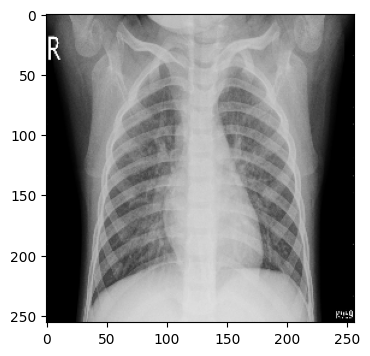

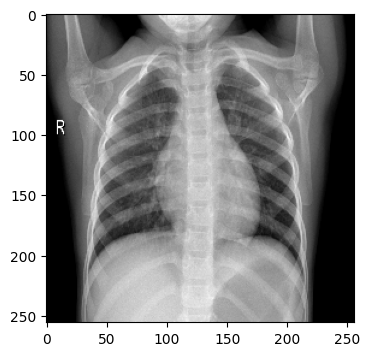

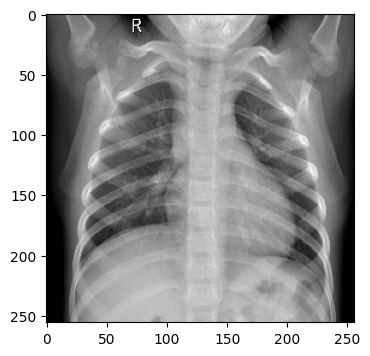

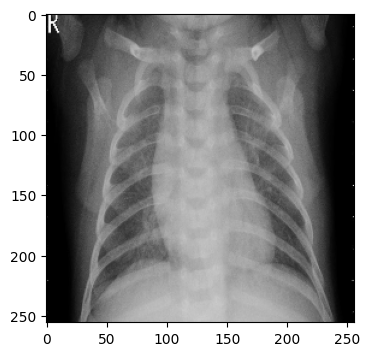

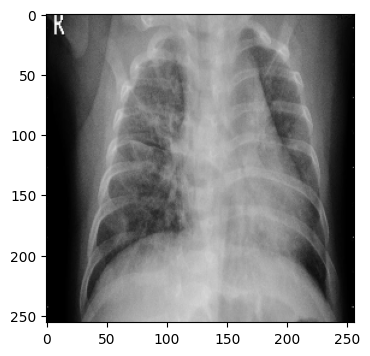

In [ ]:
for idx in range(5):
    plt.figure(figsize=(5, 4))
    plt.imshow(images[idx] / 255)
    print(f"Training Set Image Label: {labels[idx]}")
    print(f"Training Set Image Shape: {images[idx].shape}")

In [ ]:
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
    images = images.numpy()
    labels = labels.numpy()

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)
Test Set Image Label: [1. 0.]
Test Set Image Shape: (256, 256, 3)
Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)
Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)
Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


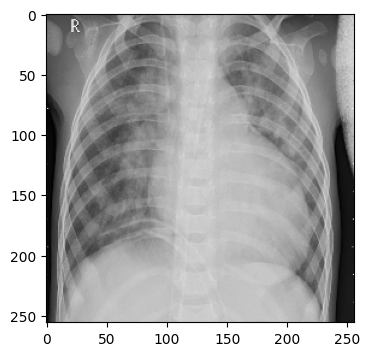

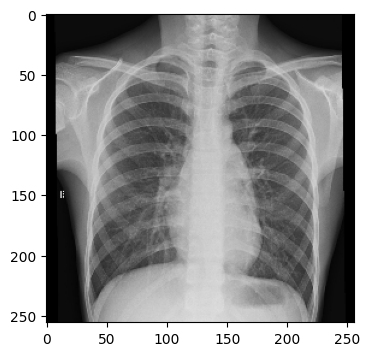

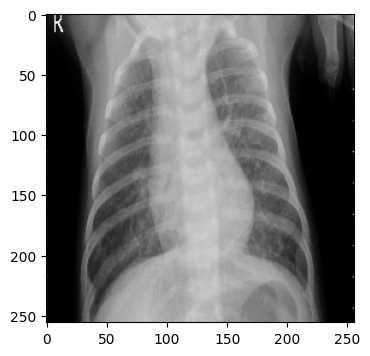

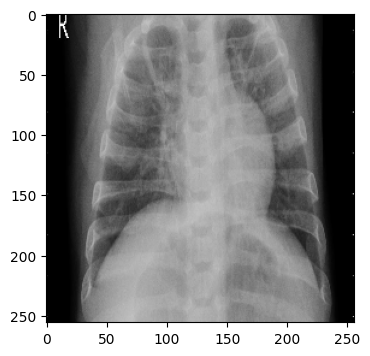

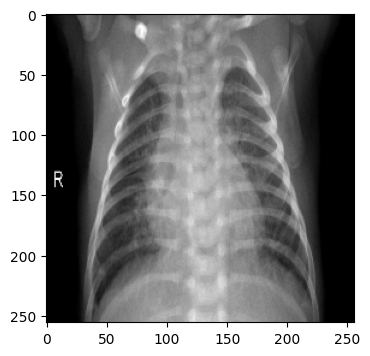

In [ ]:
for idx in range(5):
    plt.figure(figsize=(5, 4))
    plt.imshow(images[idx] / 255)
    print(f"Test Set Image Label: {labels[idx]}")
    print(f"Test Set Image Shape: {images[idx].shape}")

It is interesting how the images have 3 channels, but appear to be in grayscale format. Also, the images have different backgrounds and different scales. A more complex model would perhaps be able to pick up finer features so as to improve the classification task. We will begin this exercise with a more simple CNN model and gradually use our train and validation datasets to improve the models classification accuracy. We will use our test set to validate the final classification model.

## First Model: Simple CNN I


We will first build a simple CNN model using tensorflow's sequential API. We are then going to specify an optimizer and loss function and compile the model. We will use 5 epochs during training and evaluate the model accuracy using the validation data.

In [ ]:
cnn_model1 = tf.keras.Sequential([
    keras.Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(12, 5, activation="relu"),
    layers.MaxPool2D(3),
    layers.Flatten(),
    layers.Dense(12, activation="relu"),
    layers.Dense(2)
], name="cnn_model1")

In [ ]:
cnn_model1.summary()

Model: "cnn_model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 12)   │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 84, 84, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 84672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │     1,016,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,014 (3.88 MB)

 Trainable params: 1,017,014 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
first_optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
cnn_model1.compile(optimizer=first_optim, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
cnn_model1.fit(train_set_norm, epochs=5, validation_data=val_set_norm)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 914ms/step - accuracy: 0.7272 - loss: 0.5542 - val_accuracy: 0.7629 - val_loss: 0.3503
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 900ms/step - accuracy: 0.7676 - loss: 0.3571 - val_accuracy: 0.9130 - val_loss: 0.3017
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 905ms/step - accuracy: 0.8954 - loss: 0.3098 - val_accuracy: 0.8910 - val_loss: 0.2660
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9157 - loss: 0.2759 - val_accuracy: 0.9312 - val_loss: 0.2496
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 922ms/step - accuracy: 0.9369 - loss: 0.2699 - val_accuracy: 0.9340 - val_loss: 0.2336


The training accuracy of our first model is quite good even though we are only using 5 epochs. The validation accuracy actually rises steadily and does not deviate significantly from the training accuracy. This could potentially mean that we are overfitting. There are a number of methods we could use in order to prevent overfitting (regularization, data augmentation).

## Second Model: Optimized CNN

We are now going to further optimize the model and try to achieve the following goal of having at least 85% training and validation accuracy after 15 epochs. The number of epochs will give us an indication of the presence of overfitting.

In [ ]:
cnn_model2 = tf.keras.Sequential([
    keras.Input(shape=(img_size, img_size, 3)),
    layers.RandomRotation(factor=0.05, seed=417),
    layers.Conv2D(32, 5, activation="relu", strides=2),
    layers.MaxPool2D(3, strides=2),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(8, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2)
], name="cnn_model2")

In [ ]:
cnn_model2.summary()

Model: "cnn_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_4               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │     3,936,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,939,402 (15.03 MB)

 Trainable params: 3,939,402 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
second_optim = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
cnn_model2.compile(optimizer=second_optim, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

In [ ]:
cnn_model2.fit(train_set_norm, epochs=15, validation_data=val_set_norm, callbacks=[callback])

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 912ms/step - accuracy: 0.6257 - loss: 3.3166 - val_accuracy: 0.7629 - val_loss: 0.5631
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7272 - loss: 0.5945 - val_accuracy: 0.7629 - val_loss: 0.5356
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 903ms/step - accuracy: 0.7375 - loss: 0.5678 - val_accuracy: 0.7629 - val_loss: 0.5261
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 933ms/step - accuracy: 0.7342 - loss: 0.5653 - val_accuracy: 0.7734 - val_loss: 0.4821
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 901ms/step - accuracy: 0.7613 - loss: 0.5372 - val_accuracy: 0.7677 - val_loss: 0.4803
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 913ms/step - accuracy: 0.7677 - loss: 0.5123 - val_accuracy: 0.8403 - val_loss: 0.3717
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 899ms/step - accuracy: 0.7887 - loss: 0.4928 - val_accuracy: 0.7744 - val_loss: 0.4713
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 901ms/step - accuracy: 0.7854 - loss: 0.5015 - val_accurac

To further improve the models performance, dropout regularization, callback, stride modification, data rotation augmentation, learning rate modification for faster convergence were used to ensure good model performance and preventing overfitting behavior. These techniques are only some examples of the possibilities of regularization and hyper parameter tuning.

The validation accuracy slowly increases and reaches a final value of around 90%. The 85% threshold is first breached on epoch 9, which is good enough for our overfitting criteria.

## Evaluating on the Test Set

To evaluate the model on our test set, we are going to use the evaluate method.

In [ ]:
first_model_test_loss, first_model_test_acc = cnn_model1.evaluate(test_set_norm)

sec_model_test_loss, sec_model_test_acc = cnn_model2.evaluate(test_set_norm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7548 - loss: 0.4944
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.7404 - loss: 0.5349


In [ ]:
print(f"Test accuracy of our first CNN model is {first_model_test_acc * 100:.2f}%")

print(f"Test accuracy of our second CNN model is {sec_model_test_acc * 100:.2f}%")

Test accuracy of our first CNN model is 74.52%
Test accuracy of our second CNN model is 76.28%


The second model's test set accuracy is only slightly better than the first model. This highlights the need for final evaluation of a model's performance on unseen data to truly understand the accuracy. It is good to see that the overfitting reduction methods did not seem to harm the model's final performance. More techniques and hyperparameter optimizations can be used to further improve the performance of this model.

Additional analysis can be used to further understand the unique performance of the classification model (recall, precision, f1-score, type I and type II error rates).

The additional analysis is outside of the scope of this rather short project with an implementation of tensorflow in google colab.